# Example 1: Student modelling & prediction

Here we attempt to identify students at risk, based on their activity in Moodle. As "at risk" we identify a student that has scored lower a grade lower than 2 in the course (0 is a fail, 5 is an excellent).
## Data
we provide a file with students' grade and a file with the number of times a student has accessed a component of a certain type. 
For example, if you print the data you will see that the student with user id (uid) 10020 has accessed a URL component 22 times.

First we load the libraries that we will need

In [4]:
library("corrplot")
library("DAAG")

corrplot 0.84 loaded


In [13]:
#read the datasets containt information about accessing components and grades
component_stats = read.csv("components_stats.csv")
grades = read.csv("grades.csv")

#merge these two datasets. 
#In this way, we create a unified dataset taht associates student's online activity with performance(grades)
comp_grade = merge(component_stats, grades, by = "uid")


#lets have a look at the 10 first rows of our dataset
comp_grade[1:10,]

uid,Page,System,HotPot.module,URL,Forum,Book,Choice,Journal,File,User.report,Overview.report,Quiz,Link.set,Mindmap,Final.Grade
10020,31,265,152,22,150,26,6,16,2,15,4,7,4,0,5
10021,24,300,178,20,204,23,16,22,5,32,3,6,6,3,3
10022,19,282,245,7,115,8,9,14,11,0,0,4,5,5,4
10023,15,125,32,19,112,12,12,16,9,1,1,8,3,1,0
10024,9,184,155,3,88,18,6,15,3,22,0,7,3,2,4
10025,11,226,167,10,117,14,19,19,4,19,1,7,1,0,2
10026,25,349,230,17,281,40,33,17,4,16,1,3,1,3,4
10027,22,211,100,31,78,16,17,19,7,9,2,8,1,0,1
10028,13,84,18,11,82,12,6,13,2,0,0,0,0,2,2
10029,18,325,230,47,128,13,13,12,2,11,0,10,8,2,2


## Students at risk

In [15]:
#now lets create a variable "success" that we will use to signify students at risk
# For this example, students with success = 0 are considered to be at risk
comp_grade <- transform(comp_grade, success= ifelse(Final.Grade>= 3, 1, 0))

#lets see how it looks!
comp_grade[1:10,]

uid,Page,System,HotPot.module,URL,Forum,Book,Choice,Journal,File,User.report,Overview.report,Quiz,Link.set,Mindmap,Final.Grade,success
10020,31,265,152,22,150,26,6,16,2,15,4,7,4,0,5,1
10021,24,300,178,20,204,23,16,22,5,32,3,6,6,3,3,1
10022,19,282,245,7,115,8,9,14,11,0,0,4,5,5,4,1
10023,15,125,32,19,112,12,12,16,9,1,1,8,3,1,0,0
10024,9,184,155,3,88,18,6,15,3,22,0,7,3,2,4,1
10025,11,226,167,10,117,14,19,19,4,19,1,7,1,0,2,0
10026,25,349,230,17,281,40,33,17,4,16,1,3,1,3,4,1
10027,22,211,100,31,78,16,17,19,7,9,2,8,1,0,1,0
10028,13,84,18,11,82,12,6,13,2,0,0,0,0,2,2,0
10029,18,325,230,47,128,13,13,12,2,11,0,10,8,2,2,0


# Step 1: Identify Predictors

Then we run a correlation analysis to identify which metrics relate to student's performance. Then we plot the results of the correlation analysis!

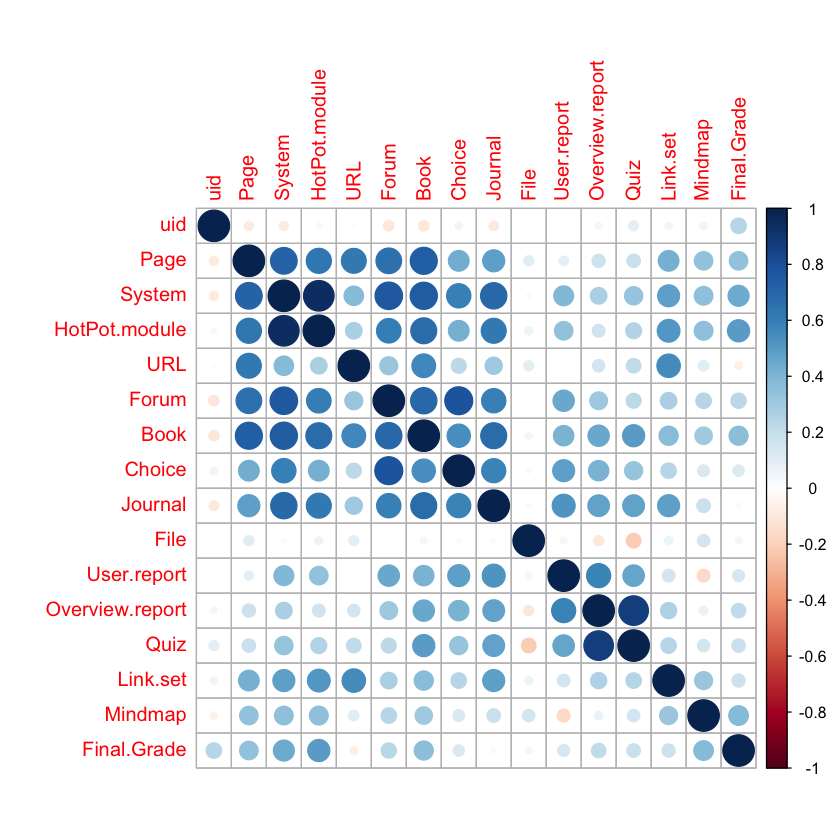

In [5]:
compcor = cor(comp_grade)
corrplot(compcor, method = "circle")

Lets see some correlations' results between specific metrics and final grade, to get a rough idea what we're talking about!

In [7]:
cor.test(comp_grade$Final.Grade,comp_grade$Page)
cor.test(comp_grade$Final.Grade,comp_grade$System)
cor.test(comp_grade$Final.Grade,comp_grade$HotPot.module)
cor.test(comp_grade$Final.Grade,comp_grade$Book)
cor.test(comp_grade$Final.Grade,comp_grade$Mindmap)


	Pearson's product-moment correlation

data:  comp_grade$Final.Grade and comp_grade$Page
t = 1.98, df = 29, p-value = 0.05726
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01053236  0.62322684
sample estimates:
      cor 
0.3450957 



	Pearson's product-moment correlation

data:  comp_grade$Final.Grade and comp_grade$System
t = 2.664, df = 29, p-value = 0.01248
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1056610 0.6894222
sample estimates:
      cor 
0.4434003 



	Pearson's product-moment correlation

data:  comp_grade$Final.Grade and comp_grade$HotPot.module
t = 3.0601, df = 29, p-value = 0.004731
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1693539 0.7219942
sample estimates:
      cor 
0.4940468 



	Pearson's product-moment correlation

data:  comp_grade$Final.Grade and comp_grade$Book
t = 2.1202, df = 29, p-value = 0.04267
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.01378667 0.63787592
sample estimates:
      cor 
0.3663372 



	Pearson's product-moment correlation

data:  comp_grade$Final.Grade and comp_grade$Mindmap
t = 2.2691, df = 29, p-value = 0.03088
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.03938462 0.65282249
sample estimates:
      cor 
0.3883057 


####################################################

## Step 2: Build a student model

Here we implement a logistic regression model to predict students at risk.
We use the metrics we explore above (components) as predictors and we attempt to predict the value of the variable "success".

Here our model is a binary classifier - 1 means the student will complete the course successfully and 0 means the student is at risk.

####################################################

In [11]:
# we train the student model using our dataset and logistic regression where success is the variable 
# we want to predict using as input the metrics:Page, System etc.
predictSuccess <- glm(success ~ Page + System + HotPot.module + Book + Mindmap, data = comp_grade, family = binomial())

#here we provide an overview of the model we just trained
summary(predictSuccess)

#print out the cross validation results for the training phase
CVbinary(predictSuccess)


Call:
glm(formula = success ~ Page + System + HotPot.module + Book + 
    Mindmap, family = binomial(), data = comp_grade)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9285  -0.1856   0.1908   0.6496   1.3539  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)  
(Intercept)    0.53801    1.37853   0.390   0.6963  
Page           0.05846    0.10709   0.546   0.5851  
System        -0.04097    0.02632  -1.557   0.1196  
HotPot.module  0.04661    0.02658   1.754   0.0795 .
Book           0.11047    0.08689   1.271   0.2036  
Mindmap        0.62952    0.52115   1.208   0.2271  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 35.403  on 30  degrees of freedom
Residual deviance: 23.839  on 25  degrees of freedom
AIC: 35.839

Number of Fisher Scoring iterations: 6



Fold:  5 8 7 6 10 9 4 3 1 2
Internal estimate of accuracy = 0.806
Cross-validation estimate of accuracy = 0.645


## Step 3: Prediction

In [21]:
#we split our dataset into two, in order to try out the prediction
trainset = comp_grade[0:27,]
testset = comp_grade[28:31,]

#we retrain the model using the trainset
predictSuccess <- glm(success ~ Page + System + HotPot.module + Book + Mindmap, data = trainset, family = binomial())

#we predict the variable success for the test set and compute the accuracy of our prediction
fitted.results <- predict(predictSuccess,newdata=testset,type='response')
fitted.results <- ifelse(fitted.results > 0.5,1,0)
misClasificError <- mean(fitted.results != test$success)
print(paste('Accuracy',1-misClasificError))


[1] "Accuracy 0.5"


## Conclusion


